**Introduction**


In this notebook, we will explore two popular model interpretability techniques: Integrated Gradients and Grad-CAM, to understand the decision-making process of a Convolutional Neural Network (CNN) trained to classify images of cats and dogs.

We will use PyTorch and the Captum library to implement these methods.

**Dataset and Model**

We have trained a CNN model on the Cats vs Dogs dataset, using data augmentation techniques to prevent overfitting and achieve good accuracy.

Now, we aim to explain the model's predictions on some test images.

**Integrated Gradients**

What is Integrated Gradients?
Integrated Gradients is an attribution method that quantifies the contribution of each input feature to the model's prediction. It addresses issues with gradient-based methods, such as saturation and thresholding, by integrating the gradients along a path from a baseline input to the actual input.

How Integrated Gradients Work
Given a function
𝐹 (our model), an input 𝑥, and a baseline input x' (e.g., an image with zero pixels), the integrated gradients are computed as:
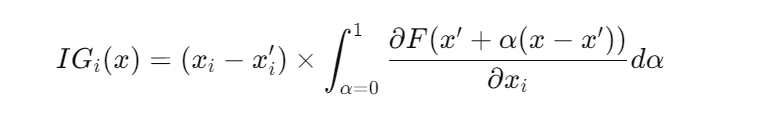
where
𝑖
i indexes the input features.

This method effectively accumulates the gradients of the model's output with respect to the input features along the straight-line path from the baseline to the input.

In [ ]:
from datasets import load_dataset

# Load the dataset
dataset = load_dataset("pantelism/cats-vs-dogs")


In [ ]:
from datasets import load_dataset, concatenate_datasets, DatasetDict
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# Load the dataset
dataset = load_dataset("pantelism/cats-vs-dogs")

# Since there's no 'test' split, we'll create one from 'train'
# Assuming you want a 80/20 train/test split
train_testvalid = dataset['train'].train_test_split(test_size=0.2, seed=42)

# Rename 'test' to 'validation' to avoid conflicts
train_testvalid['validation'] = train_testvalid.pop('test')

# Now, split 'validation' further into 'test' and 'validation' (50/50)
test_valid = train_testvalid['validation'].train_test_split(test_size=0.5, seed=42)

# Update the original dictionary with the new splits
train_testvalid['test'] = test_valid['test']
train_testvalid['validation'] = test_valid['train']  # Rename 'train' to 'validation'

# Create a new DatasetDict with the desired structure
dataset = DatasetDict(train_testvalid)

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]),
}

class CatsVsDogsDataset(Dataset):
    def __init__(self, hf_dataset, split, transform=None):
        self.dataset = hf_dataset[split]
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Get the image and label
        item = self.dataset[idx]
        image = item['image']
        label = item['label']

        # Convert image to PIL Image
        image = image.convert('RGB')

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        return image, label

# Create PyTorch datasets
train_dataset = CatsVsDogsDataset(dataset, 'train', transform=data_transforms['train'])
test_dataset = CatsVsDogsDataset(dataset, 'test', transform=data_transforms['test'])

# Define batch size
batch_size = 32

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)



In [ ]:
import torch.nn as nn
from torchvision import models

# Initialize the model
model = models.resnet18(pretrained=True)

# Modify the final layer to match the number of classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # Two classes: cats and dogs

# Move the model to the appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
num_epochs = 5  # Adjust as needed

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 10)

    # Training phase
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)

    print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    # Validation phase
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(test_dataset)
    epoch_acc = running_corrects.double() / len(test_dataset)

    print(f'Val Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}\n')

print('Training complete')
torch.save(model.state_dict(), 'model.pth')


Epoch 1/5
----------
Train Loss: 0.2536 Acc: 0.8791
Val Loss: 0.0505 Acc: 0.9825

Epoch 2/5
----------
Train Loss: 0.1387 Acc: 0.9409
Val Loss: 0.0385 Acc: 0.9850

Epoch 3/5
----------
Train Loss: 0.1125 Acc: 0.9500
Val Loss: 0.0370 Acc: 0.9800

Epoch 4/5
----------
Train Loss: 0.1291 Acc: 0.9406
Val Loss: 0.0372 Acc: 0.9900

Epoch 5/5
----------
Train Loss: 0.1183 Acc: 0.9500
Val Loss: 0.0234 Acc: 0.9925

Training complete


In [ ]:
# Initialize the model structure
model = models.resnet18()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # Two classes: cats and dogs

# Load the trained weights
model.load_state_dict(torch.load('model.pth', map_location=device))
model = model.to(device)
model.eval()
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
# Get an example from the test dataset
sample_idx = 0  # Change index to view different images
sample = dataset['test'][sample_idx]
img = sample['image'].convert('RGB')
label = sample['label']

# Preprocess the image
input_tensor = preprocess(img).unsqueeze(0).to(device)
# Get model prediction
output = model(input_tensor)
_, predicted_class = torch.max(output, 1)
predicted_class = predicted_class.item()
class_names = ['cat', 'dog']
print(f'Predicted class: {class_names[predicted_class]}')
print(f'True class: {class_names[label]}')


<ipython-input-23-15d1de725b33>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model.pth', map_location=device))


Predicted class: dog
True class: dog


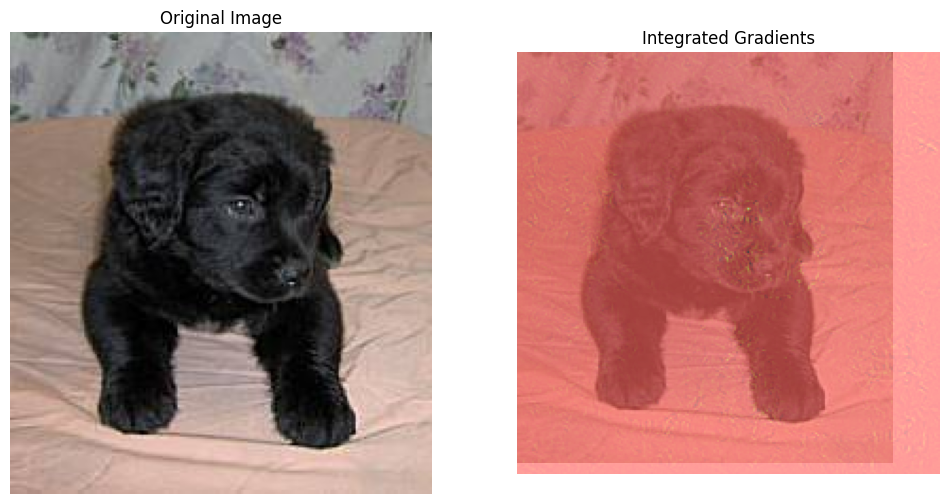

In [ ]:
from captum.attr import IntegratedGradients
import numpy as np
import matplotlib.pyplot as plt

# Initialize Integrated Gradients
ig = IntegratedGradients(model)

# Define baseline (black image)
baseline = torch.zeros_like(input_tensor).to(device)

# Compute attributions
attributions, delta = ig.attribute(
    input_tensor, baseline, target=predicted_class, return_convergence_delta=True
)

# Convert attributions to numpy
attributions = attributions.cpu().detach().numpy()[0].transpose(1, 2, 0)

# Aggregate across color channels
attributions = np.mean(attributions, axis=2)

# Normalize attributions
attributions = (attributions - attributions.min()) / (attributions.max() - attributions.min())

# Plot
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Original image
ax[0].imshow(img)
ax[0].axis('off')
ax[0].set_title('Original Image')

# Attributions
ax[1].imshow(img, alpha=0.6)
ax[1].imshow(attributions, cmap='hot', alpha=0.4)
ax[1].axis('off')
ax[1].set_title('Integrated Gradients')

plt.show()


**Grad-CAM**

What is Grad-CAM?
Gradient-weighted Class Activation Mapping (Grad-CAM) is a visualization technique for deep learning models, particularly CNNs, that highlights the regions of the input image that were important for the model's prediction.

**How Grad-CAM Works**

Grad-CAM computes the gradient of the score for a particular class with respect to feature maps of a convolutional layer, then weights these feature maps by the average of these gradients. This results in a heatmap highlighting the important regions.

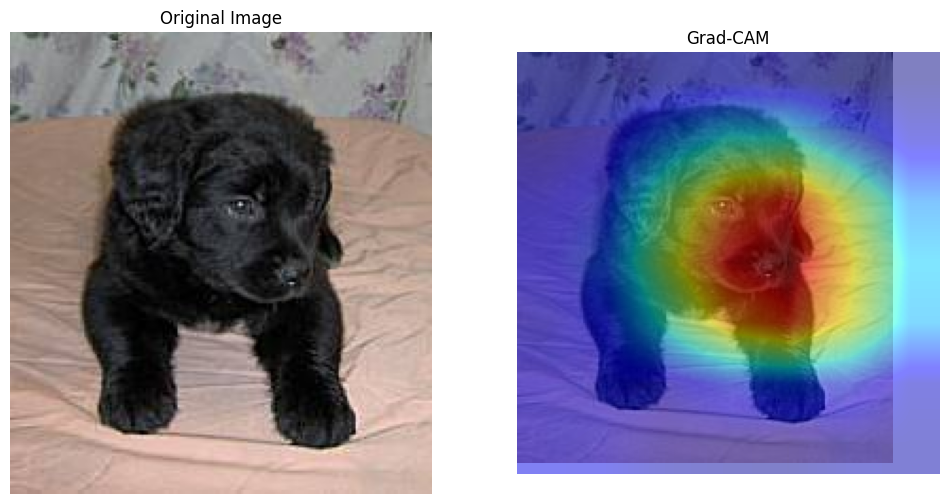

In [ ]:
from captum.attr import LayerGradCam
# Target layer for Grad-CAM
target_layer = model.layer4[1].conv2
# Initialize LayerGradCam
layer_gc = LayerGradCam(model, target_layer)
# Compute attributions
attributions = layer_gc.attribute(input_tensor, target=predicted_class)
# Upsample attributions to match input size
attributions_upsampled = torch.nn.functional.interpolate(
    attributions, size=(224, 224), mode='bilinear', align_corners=False
)
# Convert to numpy
attributions = attributions_upsampled.cpu().detach().numpy()[0][0]

# Normalize attributions
attributions = (attributions - attributions.min()) / (attributions.max() - attributions.min())

# Plot
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Original image
ax[0].imshow(img)
ax[0].axis('off')
ax[0].set_title('Original Image')

# Grad-CAM heatmap
ax[1].imshow(img)
ax[1].imshow(attributions, cmap='jet', alpha=0.5)
ax[1].axis('off')
ax[1].set_title('Grad-CAM')

plt.show()
